# Evaluation of multi-omics GRN inference methods
## Analysis of the inferred GRNs
### by Jalil Nourisa

Competition Overview: https://www.kaggle.com/competitions/open-problems-single-cell-perturbations/overview

#TODO:
- run CO for 3000 genes
- keep less links for CO
- shuffle GRN links

? random compression -> during dimensionality reduction 


- TF acitivity analysis on control
- binding affinity-based TFs of compounds 
- unpaired GRN: train on perturbation data  

# Imports

In [2]:
import os
import gzip
import pandas as pd
import numpy as np
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import tqdm
import scipy
import decoupler as dc
import seaborn as sns
import json
from scipy.sparse import csr_matrix
from venn import venn # https://github.com/LankyCyril/pyvenn/blob/master/pyvenn-demo.ipynb

surragate_names = {'collectRI':'CollectRI', 'collectRI_sign':'CollectRI-signs',
                   'sp_grn':'Scenic+', 'sp_ct':'Scenic+', 'sp_grn_sign': 'Scenic+-signs',
                   'co_grn':'CellOracle', 'co_ct':'CellOracle', 'co_grn_sign':'CellOracle-signs',
                   'figr_grn':'FigR', 'figr_ct':'FigR', 'figr_grn_sign':'FigR-signs',
                   'baseline':'Baseline'
                   }

%matplotlib inline
work_dir = '../output'
kaggle_data_dir = '../input/kaggle/input'
os.makedirs(f'{work_dir}', exist_ok=True)

train_cell_types = ['T cells CD4+', 'NK cells', 'T regulatory cells', 'T cells CD8+']
test_celltypes = ['B cells', 'Myeloid cells'] 
agg_type = ['T regulatory cells', 'T cells CD8+', 'T cells CD4+']
all_cell_types = ['T cells CD4+', 'NK cells', 'T regulatory cells', 'T cells CD8+', 'B cells', 'Myeloid cells']

def calculate_p_values(genes, df):
    '''
    We conduct a 1-sample Kolmogorov-Smirnov (KS) test to detemine p-values for each given gene versus a uniform set.
    Taken from Antoine Passiemier.
    '''
    p_values = []
    for k, gene in tqdm.tqdm(enumerate(genes)):  # Perform test for each gene
        v = df.iloc[:, k].values
        v_valid = v[~np.isnan(v)]
        if len(v_valid)<10:
            raise ValueError('shouldnt be')
        else:
            v_valid = 10 ** (-np.abs(v_valid))  # Transform DE values to p-values (assumed to be uniformly-distributed)
            res = scipy.stats.mstats.ks_1samp(v_valid, scipy.stats.uniform.cdf)  # Kolmogorov-Smirnov test
            p_value = res[1]
        p_values.append(p_value)
    p_values = np.asarray(p_values)
    return p_values



# Process multiomics data

In [65]:
multiome_var_meta = pd.read_csv(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/multiome_var_meta.csv')
multiome_train = pd.read_parquet(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/multiome_train.parquet')
multiome_obs_meta = pd.read_csv(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/multiome_obs_meta.csv')

KeyboardInterrupt: 

## scRNA-seq
We use provided normalized values as X and store the counts in the layers.

### <a id='toc4_1_1_'></a>[Formatize the data](#toc0_)

In [ ]:
from scipy.sparse import csr_matrix
import anndata

genes_locations = multiome_var_meta[multiome_var_meta['feature_type']=='Gene Expression']['location'].values
df_mrna = multiome_train[multiome_train['location'].isin(genes_locations)].reset_index(drop=True)
# get count and normalized count
df_mrna_pivot_raw = df_mrna.pivot(index='obs_id', columns='location', values='count')
df_mrna_pivot_raw = df_mrna_pivot_raw.fillna(0)
mrna_sparse_raw = csr_matrix(df_mrna_pivot_raw.values)
df_mrna_pivot_n = df_mrna.pivot(index='obs_id', columns='location', values='normalized_count')
df_mrna_pivot_n = df_mrna_pivot_n.fillna(0)
mrna_sparse_n = csr_matrix(df_mrna_pivot_n.values)

In [ ]:
adata = anndata.AnnData(X=mrna_sparse_n, 
                obs=multiome_obs_meta.set_index('obs_id'),
                var=pd.DataFrame(index=df_mrna_pivot_raw.columns),
                layers={'counts':mrna_sparse_raw}
                )
adata.shape

In [ ]:
adata.write('../output/scRNA/adata_rna.h5ad')

### Cell numbers for different cell types

In [ ]:
adata_rna = anndata.read('../output/scRNA/adata_rna.h5ad')

In [ ]:
adata_rna.layers['x_norm'] = adata_rna.X

In [ ]:
celltype_cellcounts = adata_rna.obs.groupby('cell_type').size()
aa = plt.bar(celltype_cellcounts.index, celltype_cellcounts.values)
aa = plt.xticks(rotation=45)

### Basic steps

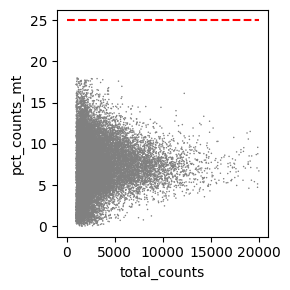

In [ ]:
adata_rna.X = adata_rna.layers['counts']
adata_rna.var['mt'] = adata_rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
import matplotlib.pyplot as plt
mito_filter = 25
fig, axs = plt.subplots(ncols = 1, figsize = (3,3))
sc.pl.scatter(adata_rna, x='total_counts', y='pct_counts_mt', ax = axs, show=False)
#draw horizontal red lines indicating thresholds.
axs.hlines(y = mito_filter, xmin = 0, xmax = max(adata_rna.obs['total_counts']), color = 'red', ls = 'dashed')
fig.tight_layout()
plt.show()

In [ ]:
adata_rna = adata_rna[adata_rna.obs.pct_counts_mt < mito_filter, :]
adata_rna

In [ ]:
import warnings
adata_rna.X = adata_rna.layers['x_norm']
with warnings.catch_warnings():
    sc.pp.filter_cells(adata_rna, min_genes=200)
    sc.pp.filter_genes(adata_rna, min_cells=3)
    warnings.simplefilter("ignore")
    sc.tl.pca(adata_rna, svd_solver='arpack', use_highly_variable=False)
    sc.pp.neighbors(adata_rna, n_neighbors=20, n_pcs=50)
    sc.tl.umap(adata_rna)

In [ ]:
sc.tl.diffmap(adata_rna)
# Calculate neihbors again based on diffusionmap 
sc.pp.neighbors(adata_rna, n_neighbors=10, use_rep='X_diffmap')
# # louvain 
sc.tl.louvain(adata_rna, resolution=0.8)
sc.tl.paga(adata_rna, groups='louvain')
# paga
sc.pl.paga(adata_rna)
sc.tl.draw_graph(adata_rna, init_pos='paga', random_state=123)

### <a id='toc4_1_4_'></a>[UMAP plot based on scRNA-seq](#toc0_)
We first plot the UMAP for all donors and individual cell types. 

/root/anaconda3/envs/py10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/anaconda3/envs/py10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


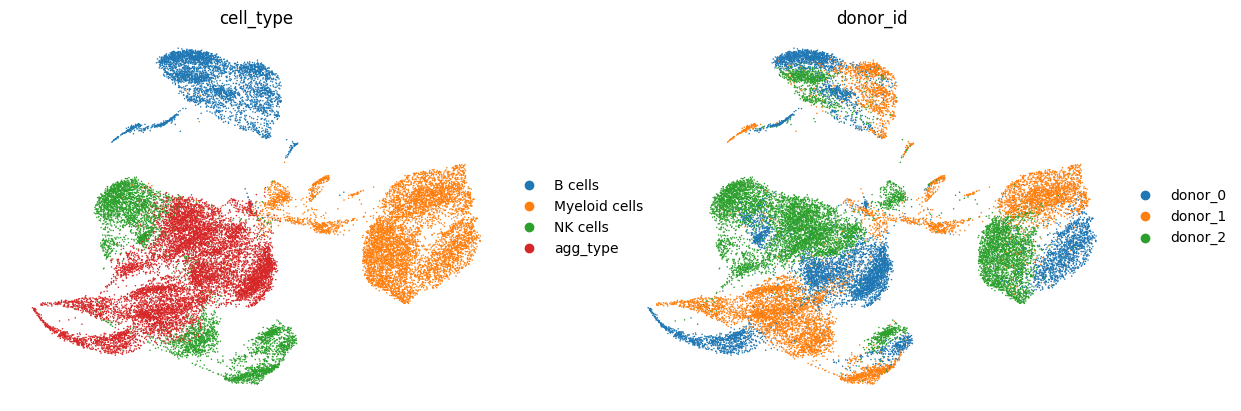

In [ ]:
sc.pl.umap(adata_rna, color=['cell_type', 'donor_id'], frameon=False)

As can be seen, the cell types of B cells and Myeloid cells are clearly seperated while there is more overlap between other cell types. We can also see the under represenation of T cells CD8+ and T regulatory cells. These two cell types are somewhat blended with T cells CD4+. We dont see any clear seggregation for donor_id.

In [ ]:
adata_rna.write('../output/scRNA/adata_rna.h5ad')

### Rank genes


In [ ]:
if 'obs' in adata_rna.uns:
    adata_rna.obs = adata_rna.uns['obs']
    sc.tl.rank_genes_groups(adata_rna, 'cell_type', method='t-test')
    sc.pl.rank_genes_groups(adata_rna, n_genes=25, sharey=False, ncols=2)  # Visualize top 25 genes

In [ ]:
adata_rna.uns['rank_genes_groups']['names']['B cells'][:5]

## <a id='toc4_2_'></a>[scATAC-seq](#toc0_)

### <a id='toc4_2_1_'></a>[Formatize the data](#toc0_)

In [ ]:
# extract only peaks
peaks_locations = multiome_var_meta[multiome_var_meta['feature_type']=='Peaks']['location'].values
df_peaks = multiome_train[multiome_train['location'].isin(peaks_locations)].reset_index(drop=True)
del multiome_train

In [ ]:
if True: # all donors. 
    # extract only peaks
    peaks_locations = multiome_var_meta[multiome_var_meta['feature_type']=='Peaks']['location'].values
    df_peaks = multiome_train[multiome_train['location'].isin(peaks_locations)].reset_index(drop=True)
    # del multiome_train

    # make adata for each donor and save
    def extract_count(count='count'):
        df_peaks_table = df_peaks.pivot_table(index='obs_id', columns='location', values=count)
        df_peaks_table.fillna(0, inplace=True)
        print('df_peaks table created')
        return df_peaks_table
    df_peaks_table = extract_count(count='count')
    df_peaks_table_n = extract_count(count='normalized_count')
    # create adata
    X = csr_matrix(df_peaks_table.values)
    X_norm = csr_matrix(df_peaks_table_n.values)
    locations = df_peaks_table.columns
    obs_ids = df_peaks_table.index
    cell_types = []
    for cell in obs_ids:
        cell_types.append(multiome_obs_meta[multiome_obs_meta['obs_id'] == cell].cell_type.values[0])
    obs = pd.DataFrame(index=obs_ids)
    obs['cell_type'] = cell_types
    var = pd.DataFrame(index=locations)
    adata = anndata.AnnData(X=X, obs=obs, var=var, layers={'x_norm':X_norm})
    print('adata is created')
    # save
    adata.write(f'adata_atac.h5ad')
else: # each donor seperately
    # make adata for each donor and save
    donor_id = 'donor_2' # 0, 1, 2
    obs_ids_donor = multiome_obs_meta[multiome_obs_meta['donor_id']==donor_id]['obs_id'].values 
    df_peaks_donor = df_peaks[df_peaks['obs_id'].isin(obs_ids_donor)].reset_index(drop=True)
    def extract_count(count='count'):
        df_peaks_table = df_peaks_donor.pivot_table(index='obs_id', columns='location', values=count)
        df_peaks_table.fillna(0, inplace=True)
        print('df_peaks table created')
        return df_peaks_table
    df_peaks_table = extract_count(count='count')
    df_peaks_table_n = extract_count(count='normalized_count')
    # create adata
    X = csr_matrix(df_peaks_table.values)
    X_norm = csr_matrix(df_peaks_table_n.values)
    locations = df_peaks_table.columns
    obs_ids = df_peaks_table.index
    del df_peaks_donor
    cell_types = []
    for cell in obs_ids:
        cell_types.append(multiome_obs_meta[multiome_obs_meta['obs_id'] == cell].cell_type.values[0])
    obs = pd.DataFrame(index=obs_ids)
    obs['cell_type'] = cell_types
    var = pd.DataFrame(index=locations)
    adata = anndata.AnnData(X=X, obs=obs, var=var, layers={'x_norm':X_norm})
    print('adata is created')
    # save
    adata.write(f'../output/scATAC/adata_{donor_id}.h5ad')
    print('adata saved')

In [ ]:
# add donor info
adata.obs = pd.merge(adata.obs, multiome_obs_meta[['obs_id', 'donor_id']], on='obs_id', how='left')


### <a id='toc4_2_2_'></a>[UMAP plot using scATAC-seq](#toc0_)
We use agg cell types for scenic+ only. For the remaining methods, we use individual cell types. We frist plot UMAP for all donors and individual cell types. Then, we plot the same graph for donor_0 and aggregated cell types.

In [ ]:
adata = anndata.read_h5ad(f'../output/scATAC/adata_atac.h5ad')

In [ ]:
adata.X = adata.layers['x_norm']
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['cell_type', 'donor_id'], frameon=False)

In [ ]:
adata.X = adata.layers['counts']
# save
adata.write(f'../output/scATAC/adata_atac.h5ad')
print('adata saved')

Similar to UMAP with the RNA data, We see two cell types of T cells CD8+ and T regulatory cells are somewhat blended with T cells CD4+.

## Merge cell types

In [ ]:
adata_atac = anndata.read_h5ad(f'../output/scATAC/adata_atac.h5ad')
adata_rna = anndata.read_h5ad(f'../output/scRNA/adata_rna.h5ad')

In [ ]:
adata_stack = [] 
for adata in [adata_rna, adata_atac]:
    # make it categorical
    adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
    # back up obs
    adata.uns['obs'] = adata.obs.copy()
    # agg cell type
    adata.obs.cell_type = adata.obs.cell_type.apply(lambda name: 'agg_type' if (name in agg_type) else name)

    adata_stack.append(adata)

adata_rna, adata_atac = adata_stack

In [ ]:
adata_rna

In [ ]:
adata_atac.write_h5ad(f'../output/scATAC/adata_atac.h5ad')
adata_rna.write_h5ad(f'../output/scRNA/adata_rna.h5ad')

# Process data of the open problems competition

## Original data

In [ ]:
multiome_var_meta = pd.read_csv(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/multiome_var_meta.csv')
multiome_obs_meta = pd.read_csv(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/multiome_obs_meta.csv')
de_train = pd.read_parquet(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/de_train.parquet')

In [ ]:
# main dataset
data_df = de_train.iloc[:,5:]
data_df['cell_type'] = de_train['cell_type']
data_df['sm_name'] = de_train['sm_name']
data_df = data_df.set_index(['cell_type','sm_name'])
data = data_df.values

### Stats 

In [ ]:
print(data_df.shape)
print(data_df.reset_index()['cell_type'].unique().shape)
print(data_df.reset_index()['sm_name'].unique().shape)

(614, 18211)
(6,)
(146,)


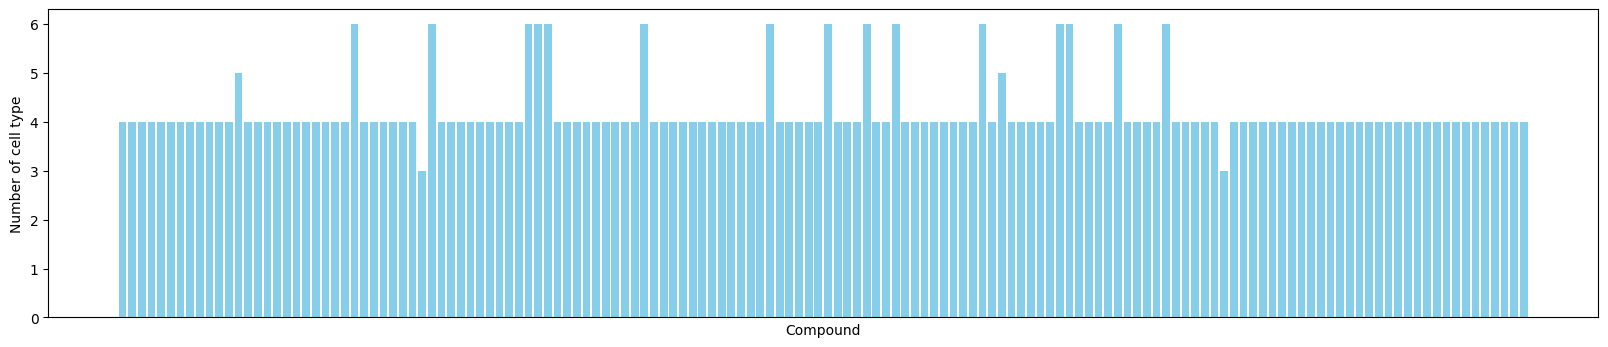

In [ ]:
compound_celltype_size = data_df.reset_index()[['sm_name', 'cell_type']].groupby('sm_name').size().reset_index().rename(columns={0:'size'})

plt.figure(figsize=(20, 4))
plt.bar(compound_celltype_size['sm_name'], compound_celltype_size['size'], color='skyblue')

plt.xlabel('Compound')
plt.ylabel('Number of cell type')
plt.xticks([])
plt.show()

### Comaring scRNA-seq to de_train: missing genes
Only 15580 genes out of 18211 genes shared between these two datasets, missing 2631 genes.

In [ ]:
gene_names = multiome_var_meta[multiome_var_meta.feature_type=='Gene Expression'].location.unique()
shared_genes = np.intersect1d(gene_names, data_df.columns)
missing_genes = np.setdiff1d(data_df.columns, shared_genes)
print(f'Genes in scRNA {len(gene_names)}, in de_train: {len(data_df.columns)}, shared : {len(shared_genes)}, missing: {len(missing_genes)}')

Genes in scRNA 22787, in de_train: 18211, shared : 15580, missing: 2631


### Gene annotation

In [ ]:
import pybiomart as pbm
species = 'hsapiens'
host = "http://sep2019.archive.ensembl.org/"   # best one
dataset = pbm.Dataset(name=species+'_gene_ensembl',  host=host)
annot = dataset.query(attributes=['chromosome_name', 'start_position', 'end_position', 'external_gene_name', 'transcript_biotype'])

annot.columns = ['chr', 'start', 'end', 'gene', 'transcript_type']
annot['width'] = annot.end-annot.start

filter = annot['chr'].str.contains('CHR|GL|JH|MT|KI27')
annot = annot[~filter].reset_index(drop=True)
# change in names
annot.chr = annot.chr.apply(lambda x:f'chr{x}')
annot.drop_duplicates(inplace=True)

In [ ]:
gene_names_annot =  annot[annot.gene.isin(data_df.columns)].reset_index(drop=True).gene.unique()
missing_genes_annot = np.setdiff1d(data_df.columns, gene_names_annot)
print('number of gene in de_train annotated ', len(gene_names_annot), 
      '/', len(data_df.columns), f' with missing {len(missing_genes_annot)}')

number of gene in de_train annotated  17687 / 18211  with missing 524


#### Transcript type of genes
Around half of the given genes are protein encoders. This shows that non-protein coding genes might play a significant role in the gene regulation.

In [ ]:
annot[annot.gene.isin(data_df.columns)].reset_index(drop=True).transcript_type.value_counts().head()

### Significance analysis DE values

In [ ]:
sig_mask = 10 ** (-np.abs(data_df)) < 0.05
df_main_sig = data_df[sig_mask]
values = df_main_sig.values.ravel()

print('Percentage of sig pvalues in df_main_imputed: ', 100*values[~np.isnan(values)].shape[0]/data_df.size)

### Significance analysis using Kolmogorov-Smirnov test

In [ ]:
de_p_values = calculate_p_values(data_df.columns, data_df)
print('number of genes with insufficient samples for p values test: ', np.isnan(de_p_values).sum())
de_p_values_valid = de_p_values[~np.isnan(de_p_values)]
print('portion of sig genes to all genes: ', (de_p_values_valid<0.001).sum()/len(de_p_values_valid))

18211it [00:11, 1523.20it/s]

number of genes with insufficient samples for p values test:  0
portion of sig genes to all genes:  0.7443852616550437


## Filtered data

### Filtering calculated on Kaggle
https://www.kaggle.com/competitions/open-problems-single-cell-perturbations/discussion/466181

In [ ]:
# filter mask
filter_mask_de = pd.read_csv(f'../input/filter_mask_de.csv', index_col=0)
filter_mask_de['cell_type'] = de_train['cell_type']
filter_mask_de['sm_name'] = de_train['sm_name']
filter_mask_de = filter_mask_de.set_index(['cell_type','sm_name'])

### Second filtering mask

In [ ]:
# only those genes with more than= 10 samples
gene_t_filter = filter_mask_de.sum()>=10
# remove those samples with less than 2000 genes
sample_t_filter = filter_mask_de.sum(axis=1)>=2000

### Apply filtering

In [ ]:
# step 1
data_df_f = data_df[filter_mask_de]
print(data_df_f.shape)
# step 2
data_df_f = data_df_f.loc[sample_t_filter, gene_t_filter]

### Stats

In [ ]:
print(data_df_f.shape)
print(data_df_f.reset_index()['cell_type'].unique().shape)
print(data_df_f.reset_index()['sm_name'].unique().shape)

In [ ]:
compound_celltype_size = data_df_f.reset_index()[['sm_name', 'cell_type']].groupby('sm_name').size().reset_index().rename(columns={0:'size'})

plt.figure(figsize=(20, 4))
plt.bar(compound_celltype_size['sm_name'], compound_celltype_size['size'], color='skyblue')

plt.xlabel('Compound')
plt.ylabel('Number of cell type')
plt.xticks([])
plt.show()

### Sparsity

In [ ]:
data_df_f.isna().sum().sum()/data_df_f.size

### What percentage of data is filtered out?

In [ ]:
1-(data_df_f.size-data_df_f.isna().sum().sum())/data_df.size

### Significance analysis

In [ ]:
sig_mask = 10 ** (-np.abs(data_df_f)) < 0.05
df_main_sig = data_df_f[sig_mask]
values = df_main_sig.values.ravel()

print('Percentage of sig pvalues in df_main_imputed: ', 100*values[~np.isnan(values)].shape[0]/data_df_f.size)

### Significance analysis using KS test

In [ ]:
# de_p_values = calculate_p_values(data_df_f.columns, data_df_f)
# print('number of genes with insufficient samples for p values test: ', np.isnan(de_p_values).sum())
# de_p_values_valid = de_p_values[~np.isnan(de_p_values)]
threshold_sig = 0.05/len(de_p_values) # adjust for multiple testing
print('portion of sig genes to all genes: ', (de_p_values_valid<threshold_sig).sum()/len(de_p_values_valid))

portion of sig genes to all genes:  0.5044753171160288


## Imputed data
This will be only used for encoding outputs

In [ ]:
if False:
    from sklearn.impute import KNNImputer
    # Creating the imputer object. You can adjust 'n_neighbors' based on your dataset size and characteristics
    imputer = KNNImputer(n_neighbors=10)
    # Imputing the missing values
    data_df_imputed = pd.DataFrame(imputer.fit_transform(data_df_f), columns=data_df_f.columns, index=data_df_f.index)
    data_df_imputed.to_csv('../input/data_df_f_imputed.csv')
else:
    data_df_imputed = pd.read_csv('../input/data_df_f_imputed.csv')
    data_df_imputed.set_index(['cell_type', 'sm_name'], inplace=True)

In [ ]:
sig_mask = 10 ** (-np.abs(data_df_imputed)) < 0.05
df_main_sig = data_df_imputed[sig_mask]
values = df_main_sig.values.ravel()

print('Percentage of sig pvalues in df_main_imputed: ', 100*values[~np.isnan(values)].shape[0]/data_df_imputed.size)

### Save

In [ ]:
data_df.reset_index().to_csv('../output/postprocess/EDA/data_df.csv')
data_df_f.reset_index().to_csv('../output/postprocess/EDA/data_df_f.csv')
data_df_imputed.reset_index().to_csv('../output/postprocess/EDA/data_df_imputed.csv')

# GRN inference analysis
For each GRN method, we provided a seperate notebook for inference process. Once the results are obtained, we continue to the next step.

## Baseline GRN inference 

In [ ]:
adata_rna = anndata.read_h5ad(f'../output/scRNA/adata_rna.h5ad')

In [ ]:
# data = adata_rna[:500,:1000].X.T
data = adata_rna.X.T
data.shape

In [ ]:
def sparse_corrcoef(A):

    A = A.astype(np.float64)
    n = A.shape[1] # sample n

    # Compute the covariance matrix
    rowsum = A.sum(1)
    centering = rowsum.dot(rowsum.T.conjugate()) / n
    C = (A.dot(A.T.conjugate()) - centering) / (n - 1)

    # The correlation coefficients are given by
    # C_{i,j} / sqrt(C_{i} * C_{j})
    d = np.diag(C)
    coeffs = C / np.sqrt(np.outer(d, d))

    return coeffs
corr_matrx = sparse_corrcoef(data)

In [ ]:
corr_matrx.shape

# Process inferred GRNs

## Load saved results

In [ ]:
collectRI = pd.read_csv('../../op_singlecell/input/collectri.csv', index_col=0)
figr_grn = pd.read_csv('../output/figr/grn.csv', index_col=0)
co_grn = pd.read_csv('../output/celloracle/grn/co_grn.csv', index_col=0)
sp_grn = pd.read_csv('../output/scenicplus/grn/grn.csv', index_col=0)

In [ ]:
grn_model_names = ["collectRI", "figr_grn", "co_grn", "sp_grn"]
grn_models = [collectRI, figr_grn, co_grn, sp_grn]
grn_models_dict = {}
for name, model in zip(grn_model_names, grn_models):
    grn_models_dict[name] = model

## Signs of GRNs
We also check GRN performance by only considering the signs of regulation instead of weight.

In [ ]:
def sign_grn(grn):
    grn_sign = grn.copy()
    weights = grn_sign.weight
    weights = [1 if weight>0 else -1 for weight in weights]
    grn_sign.weight = weights
    return grn_sign
grn_models_signs_dict = {}
for name, model in grn_models_dict.items():
    name = f'{name}_sign'
    print(name)
    grn_models_signs_dict[name] = sign_grn(model)
    if model.duplicated().sum()>0:
        duplicates = model.duplicated(keep=False)  # 'keep=False' marks all duplicates as True
        has_duplicates = duplicates.any()
        duplicated_rows = model[duplicates]
        print("Are there any duplicated rows?", has_duplicates)

collectRI_sign
figr_grn_sign
co_grn_sign
sp_grn_sign


## Combined GRN models

In [ ]:
def union_grn(df1, df2):
    '''discards those that have different signs'''
    merged_df = pd.merge(df1, df2, on=['source', 'target'], how='outer', suffixes=('_df1', '_df2'))
    flags = merged_df['weight_df1']*merged_df['weight_df2']
    print('how many links with diverge sign? ', (flags<0).sum())
    # conditions to keep 
    flags = (flags>0) | (flags.isna())
    
    merged_df = merged_df[flags]
    # remove nan
    merged_df = merged_df.fillna(1)
    merged_df['weight'] = merged_df['weight_df1']*merged_df['weight_df2']
    # 
    return merged_df[['source','target','weight']]
def intersect_grn(df1, df2):
    '''discards those that have different signs'''
    print(df1.shape, df2.shape)
    merged_df = pd.merge(df1, df2, on=['source', 'target'], how='inner', suffixes=('_df1', '_df2'))
    print(merged_df.shape)
    flags = merged_df['weight_df1']*merged_df['weight_df2']
    print('how many links with diverge sign? ', (flags<0).sum())
    # conditions to keep 
    flags = (flags>0)
    merged_df = merged_df[flags]
    merged_df['weight'] = merged_df['weight_df1']
    return merged_df[['source','target','weight']]
collectRI_figr_union_grn = union_grn(collectRI, figr_grn_sign)
# collectRI_figr_inter_grn = intersect_grn(collectRI, figr_grn)
# collectRI_figr_inter_grn

how many links with diverge sign?  44


## Save GRN models

In [ ]:
for name, grn_model in grn_models_dict.items():
    print(name)
    grn_model.to_csv(f'../output/postprocess/grn_models/{name}.csv')
for name, grn_model in grn_models_signs_dict.items():
    print(name)
    grn_model.to_csv(f'../output/postprocess/grn_models/{name}.csv')

collectRI
figr_grn
co_grn
sp_grn
collectRI_sign
figr_grn_sign
co_grn_sign
sp_grn_sign


## Cis target connections

In [ ]:
# figr
figr_ct = pd.read_csv('../output/figr/peak_gene.csv', index_col=0)[['PeakRanges', 'Gene']]
figr_ct.columns = ['cis','target']


In [ ]:
# co
co_ct = pd.read_csv('../output/celloracle/baseGRN/peak_gene.csv', index_col=0)
co_ct.columns = ['cis','target']

In [ ]:
# cp 
sp_ct = pd.read_csv('../output/scenicplus/grn/grn_extended.csv', index_col=0)[['region', 'target']].drop_duplicates()
sp_ct.columns = ['cis','target']

### Save cis target 

In [ ]:
os.makedirs('../output/postprocess/cis_target', exist_ok=True)
names_ = ["figr_ct", "sp_ct", "co_ct"]
models_ = [figr_ct, sp_ct, co_ct]

for name, grn_model in zip(names_, models_):
    grn_model.to_csv(f'../output/postprocess/cis_target/{name}.csv')


# Topological analysis of inferred GRNs

## Load GRNs

In [ ]:
grn_model_names = ['collectRI', "figr_grn", "co_grn", "sp_grn"]
grn_models_dict = {}
for name in grn_model_names:
    grn_models_dict[name] = pd.read_csv(f'../output/postprocess/grn_models/{name}.csv', index_col=0)
grn_models_signs_dict = {}
for name in grn_model_names:
    name = f'{name}_sign'
    grn_models_signs_dict[name] = pd.read_csv(f'../output/postprocess/grn_models/{name}.csv', index_col=0)


## Stats of GRN elements

### Regulatory links

In [ ]:
links_n = {name:len(grn) for name, grn in grn_models_dict.items()}
# for cell specific grn models, take the mean
links_n['co_grn'] = grn_models_dict['co_grn'].groupby('cell_type').size().mean()
print(links_n)

{'collectRI': 43178, 'figr_grn': 21324, 'co_grn': 192844.0, 'sp_grn': 33537}


### Regulatory effect

In [ ]:
regulatory_effect_dict = {}
for name, grn in grn_models_signs_dict.items():
    print('-----', name)
    if name in ['co_grn_sign']:
        celltype_counts = grn.groupby('cell_type').weight.value_counts().to_frame().reset_index()
        regulatory_effect_dict['co_grn'] = [celltype_counts[celltype_counts.weight==1]['count'].mean(), celltype_counts[celltype_counts.weight==-1]['count'].mean()]
    else:
        regulatory_effect_dict[name] = grn.weight.value_counts().values # 'positive, negative:
regulatory_effect_dict

----- collectRI_sign
----- figr_grn_sign
----- co_grn_sign
----- sp_grn_sign


{'collectRI_sign': array([37326,  5852]),
 'figr_grn_sign': array([15761,  5563]),
 'co_grn': [119724.0, 73120.0],
 'sp_grn_sign': array([33102,   435])}

### TFs and target genes

In [ ]:
target_genes_dict = {}
tfs_dict = {}
for name, grn in grn_models_dict.items():
    tfs_dict[name] = grn.source.unique() 
    target_genes_dict[name] = grn.target.unique().tolist()

In [ ]:
print('number of TFs')
tfs_dict_n =  {key:len(values) for key,values in tfs_dict.items()}
print(tfs_dict_n)
print('number of targets')
target_genes_dict_n = {key:len(values) for key,values in target_genes_dict.items()}
target_genes_dict_n

number of TFs
{'collectRI': 1186, 'figr_grn': 818, 'co_grn': 593, 'sp_grn': 140}
number of targets


{'collectRI': 6692, 'figr_grn': 7134, 'co_grn': 11497, 'sp_grn': 10789}

### DORCS

In [ ]:
names_ = ["figr_ct", "sp_ct", "co_ct"]
cis_target_df_dict = {}
for name in names_:
    model = pd.read_csv(f'../output/postprocess/cis_target/{name}.csv', index_col=0)
    cis_target_df_dict[name] = model

In [ ]:
# multiple thresholds 
dorcs_n_dict = {}
thresholds_dorcs = range(5, 20)
for name, df in cis_target_df_dict.items():
    stack_ = []
    for t in thresholds_dorcs:
        stack_.append((df.groupby('target').size()>=t).sum())
    dorcs_n_dict[name] = stack_

### Master TFs

In [ ]:
# range of thresholds 
thresholds_master_TFs = range(100,5000,10)
master_tfs_n_dict = {}
for name, grn in grn_models_dict.items():
    stack_ = []
    for t in thresholds_master_TFs:
        size_ = grn.groupby('source').size()
        tfs_n = (size_>=t).sum()
        stack_.append(tfs_n)
    master_tfs_n_dict[name] = stack_

### In-degree for target genes

In [ ]:
thresholds_indegree = range(5,50,1)
indegree_n_dict = {}
for name, grn in grn_models_dict.items():
    stack_ = []
    for t in thresholds_indegree:
        size_ = grn.groupby('target').size()
        tfs_n = (size_>=t).sum()
        stack_.append(tfs_n)
    indegree_n_dict[name] = stack_

### Plot number of GRN elements 

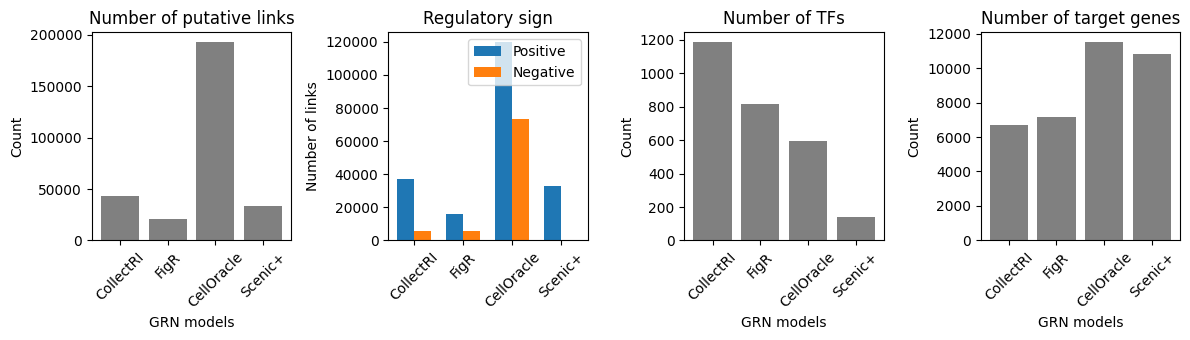

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3.5)) 
color = 'grey'
## number of links
ax = axes[0]
links_n_ = {surragate_names[key]:value for key,value in links_n.items()}
ax.bar(links_n_.keys(), links_n_.values(), color=color)
ax.set_xlabel('GRN models')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=45)
ax.set_title('Number of putative links')
# regulatory role 
ax = axes[1]
data = regulatory_effect_dict
categories = list(data.keys())
positive_counts = [data[category][0] for category in categories]
negative_counts = [data[category][1] for category in categories]
x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
bars1 = ax.bar(x - width/2, positive_counts, width, label='Positive')
bars2 = ax.bar(x + width/2, negative_counts, width, label='Negative')
ax.set_ylabel('Number of links')
ax.set_title('Regulatory sign')
ax.set_xticks(x)
ax.set_xticklabels([surragate_names[category] for category in categories])
ax.tick_params(axis='x', rotation=45)
ax.legend()

# Rotate category names for better readability
plt.xticks(rotation=45)
## number of TFs
ax = axes[2]
links_n_ = {surragate_names[key]:value for key,value in tfs_dict_n.items()}
ax.bar(links_n_.keys(), links_n_.values(), color=color)
ax.set_xlabel('GRN models')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=45)
ax.set_title('Number of TFs')
## number of target 
ax = axes[3]
links_n_ = {surragate_names[key]:value for key,value in target_genes_dict_n.items()}
ax.bar(links_n_.keys(), links_n_.values(), color=color)
ax.set_xlabel('GRN models')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=45)
ax.set_title('Number of target genes')
plt.tight_layout()


### Plot intersection of GRN elements
venn diagram

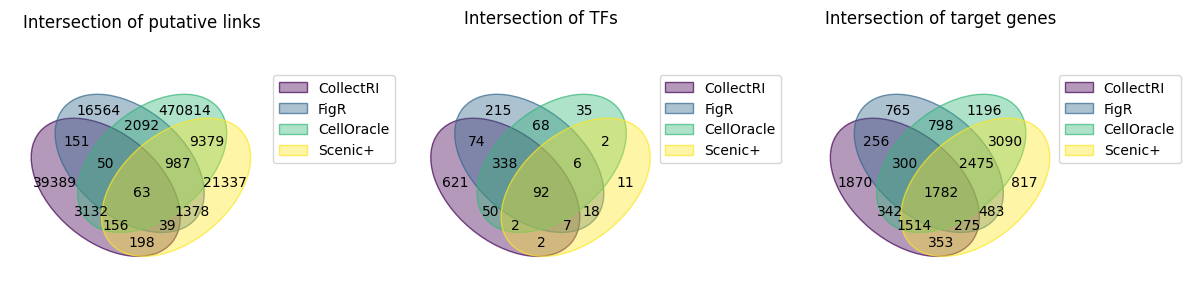

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4)) 
# links
ax = axes[0]
grn_fused_dict = {}
for name, grn in grn_models_dict.items():
    grn['link'] = grn['source']+'_'+grn['target']
    grn_fused_dict[name] = grn['link']
grn_fused_dict = {}
for name, grn in grn_models_dict.items():
    grn['link'] = grn['source']+'_'+grn['target']
    grn_fused_dict[name] = grn['link']

dict_set = {surragate_names[key]:set(item) for key,item in grn_fused_dict.items()}
aa = venn(dict_set, hint_hidden=False, fontsize=10, legend_loc=(1,.5), ax=ax)
aa = ax.set_title('Intersection of putative links',pad=1)
# TFs 
ax = axes[1]
tfs_dict_set = {surragate_names[key]:set(item) for key,item in tfs_dict.items()}
aa = venn(tfs_dict_set, hint_hidden=False, 
    figsize=(6, 6), fontsize=10, legend_loc=(.95,.5), ax=ax)
ax.set_title('Intersection of TFs')
# targets 
ax = axes[2]
target_genes_set = {surragate_names[key]:set(item) for key,item in target_genes_dict.items()}
aa = venn(target_genes_set, hint_hidden=False, 
    figsize=(6, 6), fontsize=10, legend_loc=(.95,.5), ax=ax)
ax.set_title('Intersection of target genes')
plt.tight_layout()

#### upsetplot of GRN elements

target genes
TFs


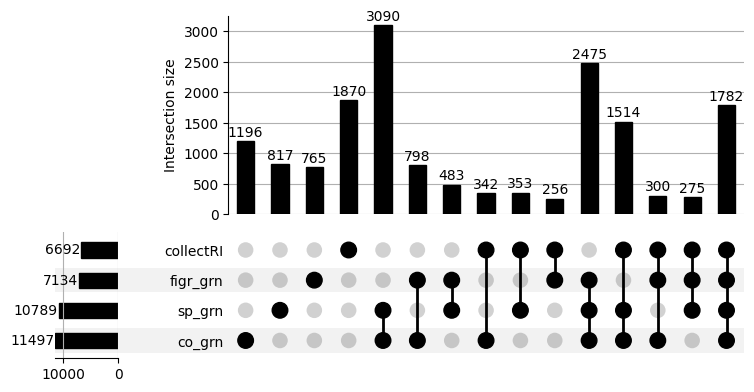

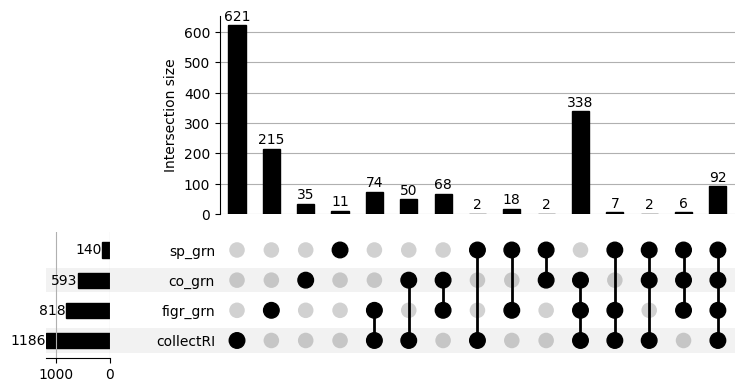

In [ ]:
# Create a set of all unique genes
def convert_df(data):
    all_genes = list(set(gene for genes in data.values() for gene in genes))

    # Initialize DataFrame
    df = pd.DataFrame(index=all_genes)

    # Populate DataFrame
    for key, genes in data.items():
        df[key] = df.index.isin(genes)
    return df
from upsetplot import from_indicators, plot
print('target genes')
aa = plot(from_indicators(indicators=lambda a: a==True, data=convert_df(target_genes_dict)), show_counts=True)
print('TFs')
aa = plot(from_indicators(indicators=lambda a: a==True, data=convert_df(tfs_dict)), show_counts=True)

### Plot connectivity (DORCs, master TFs, etc)

/tmp/ipykernel_149753/1234509918.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


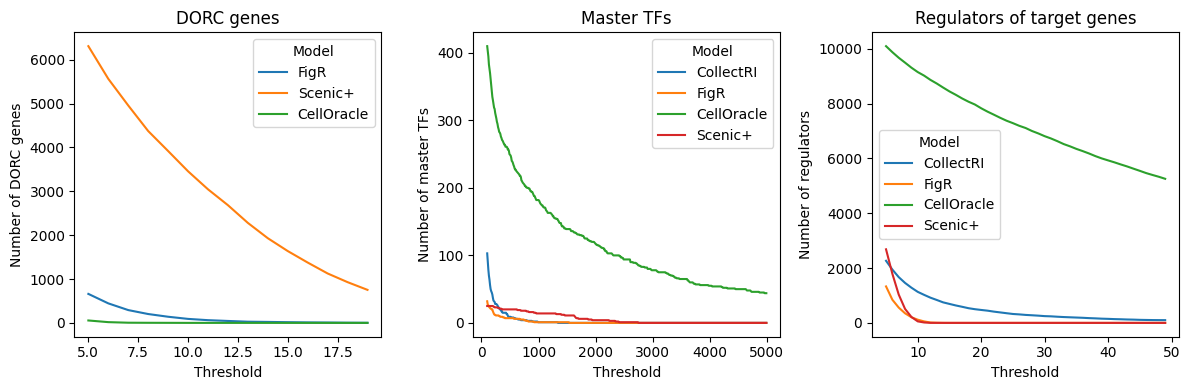

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4)) 
## DORCs
ax = axes[0]
data = dorcs_n_dict
x_range = thresholds_dorcs

for key in data:
    ax.plot(x_range, data[key], label=surragate_names[key])
ax.set_xlabel('Threshold')
ax.set_ylabel('Number of DORC genes')
ax.set_title('DORC genes')
ax.legend(title='Model')
## master TFs
ax = axes[1]
data = master_tfs_n_dict
x_range = thresholds_master_TFs
for key in data:
    ax.plot(x_range, data[key], label=surragate_names[key])
ax.set_xlabel('Threshold')
ax.set_ylabel('Number of master TFs')
ax.set_title('Master TFs')
ax.legend(title='Model')
plt.tight_layout()
## in degree for target genes 
ax = axes[2]
data = indegree_n_dict
x_range = thresholds_indegree
for key in data:
    ax.plot(x_range, data[key], label= surragate_names[key])
ax.set_xlabel('Threshold')
ax.set_ylabel('Number of regulators')
ax.set_title('Regulators of target genes')
ax.legend(title='Model')
plt.tight_layout()


# Missingness analysis


In [ ]:
original_data = True

In [ ]:
if original_data:
    df_main = pd.read_csv('../output/postprocess/EDA/data_df.csv', index_col=0).set_index(['cell_type', 'sm_name'])
else:
    df_main = pd.read_csv('../output/postprocess/EDA/data_df_f.csv', index_col=0).set_index(['cell_type', 'sm_name'])


## Missing significant target genes 

In [ ]:
de_p_values = calculate_p_values(df_main.columns, df_main)

18211it [00:12, 1515.73it/s]


In [ ]:
def evaluate_sig_gene_missing(missing_genes, df_main, threshold=0.05):
    sig_t = threshold/len(de_p_values) # accounting for multiple testing
    sig_mask = de_p_values < sig_t
    sig_genes = df_main.columns[sig_mask]
    missing_sig_genes = np.intersect1d(missing_genes, sig_genes)
    return  missing_sig_genes
missing_genes_dict = {}
missing_sig_genes_n_dict = {}
thresholds_sigs = [0.05, 0.01, 0.001, 0.0001]
for name, grn in grn_models_dict.items():
    print(f'\n------ {name}-------')
    genes = grn.target.unique()
    shared_genes = np.isin(df_main.columns, genes)
    missing_genes = df_main.columns[~shared_genes].tolist()
    missing_genes_dict[name] = missing_genes
    stack_ = []
    for t in thresholds_sigs:
        missing_sig_genes = evaluate_sig_gene_missing(missing_genes, df_main, threshold=t)
        stack_.append(len(missing_sig_genes))
    missing_sig_genes_n_dict[name] = stack_


------ collectRI-------

------ figr_grn-------

------ co_grn-------

------ sp_grn-------


In [ ]:
print('missing genes')
print({surragate_names[key]:len(value) for key,value in missing_genes_dict.items()})
print('missing sig genes for different thresholds')
missing_sig_genes_n_dict

missing genes
{'CollectRI': 13580, 'FigR': 12001, 'CellOracle': 7219, 'Scenic+': 8452}
missing sig genes for different thresholds


{'collectRI': [7091, 6058, 4546, 3150],
 'figr_grn': [6305, 5399, 4063, 2843],
 'co_grn': [5323, 4627, 3494, 2421],
 'sp_grn': [5665, 4899, 3679, 2552]}

### intersection of missing target genes 

In [ ]:

missing_sig_genes_001_dict = {}
for name, grn in grn_models_dict.items():
    print(f'\n------ {name}-------')
    genes = grn.target.unique()
    shared_genes = np.isin(df_main.columns, genes)
    missing_genes = df_main.columns[~shared_genes].tolist()
    
    missing_sig_genes_001_dict[name] = evaluate_sig_gene_missing(missing_genes, df_main, threshold=0.001)


------ collectRI-------
['A1BG', 'A1BG-AS1', 'A2M-AS1', 'A2MP1', 'AAAS']

------ figr_grn-------
['A1BG-AS1', 'A2MP1', 'A4GALT', 'AACS', 'AAGAB']

------ co_grn-------
['A1BG', 'A1BG-AS1', 'A2M-AS1', 'A2MP1', 'A4GALT']

------ sp_grn-------
['A1BG-AS1', 'A2M-AS1', 'A2MP1', 'A4GALT', 'AAR2']


## Missing significant measurments 

In [ ]:
def evaluate_sig_measur(genes, df_main, threshold=0.05):
    sig_t = threshold
    df_sg = 10 ** (-np.abs(df_main))
    
    all_sig = (df_sg < sig_t).sum().sum()
    
    mask_missing = ~df_main.columns.isin(genes)
    # print(df_sg.loc[:,mask_missing].shape)
    # print(df_sg.loc[:,mask])
    missing_sig = (df_sg.loc[:,mask_missing] < sig_t).sum().sum() 
    return  missing_sig/all_sig
missing_sig_measur = {}
thresholds_sigs = [0.05, 0.01, 0.001, 0.0001]
for name, grn in grn_models_dict.items():
    print(f'\n------ {name}-------')
    genes = grn.target.unique()
    stack_ = []
    for t in thresholds_sigs:
        missing_sig = evaluate_sig_measur(genes, df_main, threshold=t)
        stack_.append(missing_sig)
    missing_sig_measur[name] = stack_


------ collectRI-------

------ figr_grn-------

------ co_grn-------

------ sp_grn-------


## Plot missingness

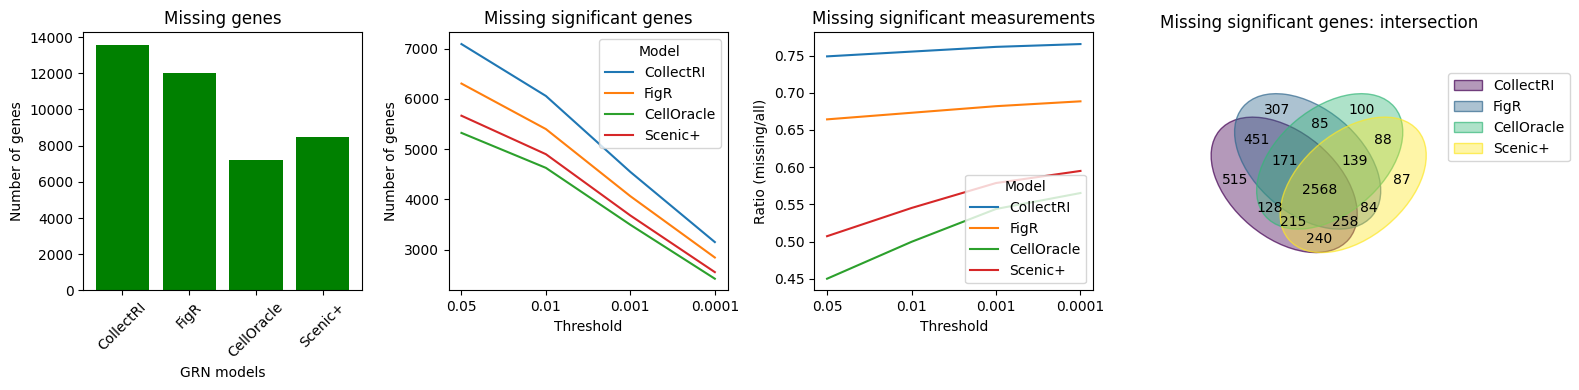

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4)) 
# missing genes 
ax = axes[0]
links_n_ = {surragate_names[key]:len(value) for key,value in missing_genes_dict.items()}
ax.bar(links_n_.keys(), links_n_.values(), color=color)
ax.set_xlabel('GRN models')
ax.set_ylabel('Number of genes')
ax.tick_params(axis='x', rotation=45)
ax.set_title('Missing genes')
## missing sig genes 
ax = axes[1]
data = missing_sig_genes_n_dict
x_range = thresholds_sigs
for key in data:
    ax.plot(range(len(x_range)),data[key], label=surragate_names[key])
ax.set_xlabel('Threshold')
ax.set_ylabel('Number of genes')
ax.set_title('Missing significant genes')
ax.set_xticks(range(len(x_range)))
ax.set_xticklabels(x_range)
ax.legend(title='Model')
## missing sig measurements
ax = axes[2]
data = missing_sig_measur
x_range = thresholds_sigs
for key in data:
    ax.plot(range(len(x_range)),data[key], label=surragate_names[key])
ax.set_xlabel('Threshold')
ax.set_ylabel('Ratio (missing/all)')
ax.set_title('Missing significant measurements')
ax.set_xticks(range(len(x_range)))
ax.set_xticklabels(x_range)
ax.legend(title='Model')
## intersection 
ax = axes[3]
dict_set = {surragate_names[key]:set(item) for key,item in missing_sig_genes_001_dict.items()}
aa = venn(dict_set, hint_hidden=True, fontsize=10, legend_loc=(1,.5), ax=ax)
aa = ax.set_title('Missing significant genes: intersection',pad=1)

plt.tight_layout()

In [ ]:
# housekeeping genes
df = pd.read_csv('https://www.tau.ac.il/~elieis/HKG/HK_genes.txt', sep=' ', header=None)
housekeeping_genes = df.loc[:, 0]  # Gene names
housekeeping_genes_filter = np.isin(data_df.columns, housekeeping_genes)
print(f'Number of housekeeping genes: {len(housekeeping_genes)}')

# Regression analysis 

In [3]:
subset_genes = False # run only for subset of genes given in the grn model
data_type = 'raw' # 'de_train_f', 'raw'
only_sig_de = False

cv_scheme = 'sm_name_10' # 'cell_type', 'sm_name', '10cv', 'sm_name_10'
metric_type = 'r2'

## Training data

In [4]:
print(data_type)
if data_type == 'de_train':
    df_main_reg = pd.read_csv('../output/postprocess/EDA/data_df.csv', index_col=0).set_index(['cell_type', 'sm_name'])
elif data_type == 'de_train_f':
    df_main_reg = pd.read_csv('../output/postprocess/EDA/data_df_f.csv', index_col=0).set_index(['cell_type', 'sm_name'])
elif data_type == 'raw':
    df_main_reg = pd.read_csv(f'../output/de_analysis/bulk_adata_df.csv', index_col=0)
    gene_names = df_main_reg.columns[15:]
    index_columns = ['cell_type', 'sm_name', 'plate_name', 'donor_id', 'row']
    df_main_reg = df_main_reg.set_index(index_columns)[gene_names]
else:
    raise ValueError('')
real_values_mask = ~df_main_reg.isna()
if False:

    print('ratio of sparsity:', 1-real_values_mask.sum().sum()/real_values_mask.size)
    sig_mask = sig_mask = 10 ** (-np.abs(df_main_reg)) < 0.05
    print('ratio of sig:', sig_mask.sum().sum()/sig_mask.size)
    # set those nans to zero
    df_main_reg.isna().sum().sum()/df_main_reg.size
    df_main_reg.fillna(0, inplace=True)
if only_sig_de:
    # set non sig DE to 0 
    p_values = 10**(-np.abs(df_main_reg))
    sig_mask = p_values<0.05
    p_values_rows = (sig_mask).sum(axis=1)
    df_main_reg = df_main_reg[sig_mask].fillna(0)

raw


## Encoder model and enrichment scheme 

In [5]:
def enrich_tfs_single(df_main_c, net):
    tf_act, p_values = dc.run_ulm(
                df_main_c,
                net,
                source='source',
                target='target',
                weight='weight',
                verbose=True
                )
    # tf_act = tf_act.set_index(df_main.index, drop=True)
    return tf_act
def enrich_tfs(df_main, net):
    "TF enrichment score cell specific grns"
    df_main_c = df_main.copy()
    df_main_c.index = df_main.index.map(lambda x: '@'.join(map(str, x))) # this is needed for enrichment analyisis
    if 'cell_type' in net:
        cell_type_index = df_main.index.get_level_values('cell_type')
        # EA for each cell type
        tf_act_stack = []
        for cell_type in net.cell_type.unique():
            if cell_type == 'agg_type':
                mask = cell_type_index.isin(agg_type)
            else:
                mask = cell_type_index==cell_type
            df_main_celltype = df_main_c[mask]

            net_celltype = net[net.cell_type==cell_type]
            tf_act = enrich_tfs_single(df_main_celltype, net_celltype)
            tf_act_stack.append(tf_act)
        tf_act_df = pd.concat(tf_act_stack).fillna(0)
        tf_act_df = tf_act_df.reindex(df_main_c.index)
            
    else:
        tf_act_df = enrich_tfs_single(df_main_c, net)
    return tf_act_df
# net = figr_grn
# df_main_copy = df_main_reg.copy()
# tf_acts =  enrich_tfs(df_main_copy, net)

In [19]:
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
import decoupler as dc
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, KFold

random_state = 32
id_map = pd.read_csv(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/id_map.csv', index_col=0)
class model_encoder_legecy:
    def __init__(self, df_main, n_components=35, shares={
                                        'sm_name':{'de_x':35},
                                        'cell_type': {'de_x':6}
                                        },
                                        te_params = dict(min_samples_leaf=20, smoothing=100),
                                        grn_model=None
                                        ):  
        # target df to encode
        self.df_main = df_main
        self.grn_model = grn_model
        # regressor
        self.emb_model = RandomForestRegressor(n_estimators=100, random_state=random_state)
        # reducer
        self.reducer = TruncatedSVD(n_components=n_components, n_iter=12, random_state=random_state)
        self.Y = self.reducer.fit_transform(df_main)
        # encoder 
        self.enc = ce.TargetEncoder(**te_params) #[0, 0.05, 0.5, 0.1,0.9,10]
        # encode data
        var_x_name = list(shares['sm_name'].keys())[0]
        n_components = shares['sm_name'][var_x_name]
        y_sm_name = self.create_feature_space(self.df_main, var_x=var_x_name, n=n_components)
        
        # cell type
        var_x_name = list(shares['cell_type'].keys())[0]
        n_components = shares['cell_type'][var_x_name]
        y_cell_type = self.create_feature_space(self.df_main, var_x=var_x_name, n=n_components)
        # the order is important
        self.emb_data = {'sm_name':y_sm_name, 'cell_type': y_cell_type}
        self.determine_X()
        print(self.X.shape, self.X_submit.shape)

    def determine_X(self):
        for i, (name, y) in enumerate(self.emb_data.items()):
            for i_target in tqdm.tqdm(range(y.shape[1])):
                if i_target == 0:
                    X_encoded = self.enc.fit_transform(self.df_main.reset_index()[name], y[:,i_target])
                    X_submit_encoded = self.enc.transform(id_map.reset_index()[name])
                else:
                    X_encoded_tmp = self.enc.fit_transform(self.df_main.reset_index()[name], y[:,i_target])
                    X_encoded = np.concatenate( [X_encoded, X_encoded_tmp], axis = 1)
                    X_encoded_tmp = self.enc.transform(id_map.reset_index()[name])
                    X_submit_encoded = np.concatenate([X_submit_encoded, X_encoded_tmp], axis = 1)
            if i == 0:
                X = X_encoded
                X_submit = X_submit_encoded
            else:
                X = np.concatenate([X, X_encoded], axis = 1)
                X_submit = np.concatenate([X_submit, X_submit_encoded], axis = 1)

        self.X = X
        self.X_submit = X_submit
    def create_feature_space(self, df_to_encode, var_x='sm_name', n=35):
        
        if var_x == 'de_x':
            return TruncatedSVD(n_components=n, n_iter=12, random_state=random_state).fit_transform(df_to_encode.values)

        elif var_x == 'tf_x':
            df_main_c = df_to_encode.copy()
            net = self.grn_model
            tf_act = enrich_tfs(df_main_c, net)

            tf_act = TruncatedSVD(n_components=n, n_iter=12, random_state=random_state).fit_transform(tf_act)
            return tf_act
        raise ValueError('define feature space')
    def validate(self, mask_tr, mask_va):
        # print(mask_tr)
        X_tr, Y_tr = self.X[mask_tr,:], self.Y[mask_tr,:]
        X_va = self.X[mask_va,:]
        self.emb_model.fit(X_tr, Y_tr)
        return self.reducer.inverse_transform(self.emb_model.predict(X_va))
    def calculate_y_submit(self):
        self.emb_model.fit(self.X, self.Y)
        return self.reducer.inverse_transform(self.emb_model.predict(self.X_submit))

class model_encoder:
    def __init__(self, df_main, n_components=35, shares={
                                        'sm_name':{'de_x':35},
                                        'cell_type': {'de_x':6}
                                        },
                                        te_params = dict(min_samples_leaf=20, smoothing=100),
                                        grn_model=None
                                        ):  
        # target df to encode
        self.df_main = df_main
        self.grn_model = grn_model
        # regressor
        self.emb_model = RandomForestRegressor(n_estimators=100, random_state=random_state)
        # reducer
        self.reducer = TruncatedSVD(n_components=n_components, n_iter=12, random_state=random_state)
        self.Y = self.reducer.fit_transform(df_main)
        # encoder 
        self.enc = ce.TargetEncoder(**te_params) #[0, 0.05, 0.5, 0.1,0.9,10]
        # encode data
        var_x_name = list(shares['sm_name'].keys())[0]
        n_components = shares['sm_name'][var_x_name]
        y_sm_name = self.create_feature_space(self.df_main, var_x=var_x_name, n=n_components)
        
        # cell type
        var_x_name = list(shares['cell_type'].keys())[0]
        n_components = shares['cell_type'][var_x_name]
        y_cell_type = self.create_feature_space(self.df_main, var_x=var_x_name, n=n_components)
        # the order is important
        self.emb_data = {'sm_name':y_sm_name, 'cell_type': y_cell_type}
        self.determine_X()
        print(self.X.shape, self.X_submit.shape)

    def determine_X(self):
        for i, (name, feature_x) in enumerate(self.emb_data.items()):
            for i_target in tqdm.tqdm(range(feature_x.shape[1])):
                if i_target == 0:
                    # print(feature_x[:,i_target])
                    X_encoded = self.enc.fit_transform(self.df_main.reset_index()[name], feature_x[:,i_target])
                    X_submit_encoded = self.enc.transform(id_map.reset_index()[name])
                else:
                    X_encoded_tmp = self.enc.fit_transform(self.df_main.reset_index()[name], feature_x[:,i_target])
                    X_encoded = np.concatenate( [X_encoded, X_encoded_tmp], axis = 1)
                    X_encoded_tmp = self.enc.transform(id_map.reset_index()[name])
                    X_submit_encoded = np.concatenate([X_submit_encoded, X_encoded_tmp], axis = 1)
            if i == 0:
                X = X_encoded
                X_submit = X_submit_encoded
            else:
                X = np.concatenate([X, X_encoded], axis = 1)
                X_submit = np.concatenate([X_submit, X_submit_encoded], axis = 1)

        self.X = X
        self.X_submit = X_submit
    def create_feature_space(self, df_to_encode, var_x='sm_name', n=35):
        if var_x == 'de_x':
            return TruncatedSVD(n_components=n, n_iter=12, random_state=random_state).fit_transform(df_to_encode.values)

        elif var_x == 'tf_x':
            df_main_c = df_to_encode.copy()
            net = self.grn_model
            tf_act = enrich_tfs(df_main_c, net)

            # tf_act = TruncatedSVD(n_components=n, n_iter=12, random_state=random_state).fit_transform(tf_act)
            variances = tf_act.var()
            sorted_variances = variances.sort_values(ascending=False)
            top_tfs = sorted_variances.head(n).index.tolist()

            tf_act = tf_act[top_tfs].values
            return tf_act
        raise ValueError('define feature space')
    def validate(self, mask_tr, mask_va):
        # print(mask_tr)
        X_tr, Y_tr = self.X[mask_tr,:], self.Y[mask_tr,:]
        X_va = self.X[mask_va,:]
        self.emb_model.fit(X_tr, Y_tr)
        return self.reducer.inverse_transform(self.emb_model.predict(X_va))
    def calculate_y_submit(self):
        self.emb_model.fit(self.X, self.Y)
        return self.reducer.inverse_transform(self.emb_model.predict(self.X_submit))

class model_encoder_raw:
    def __init__(self, df_main, n_components_y=35, 
                 n_highlyvarible_tfs = 100,
                    te_params = dict(min_samples_leaf=20, smoothing=100),
                    grn_model=None
                    ):  
        # target df to encode
        self.n_highlyvarible_tfs = n_highlyvarible_tfs
        self.df_main = df_main
        self.grn_model = grn_model
        # regressor
        self.emb_model = RandomForestRegressor(n_estimators=100, random_state=random_state)
        # reducer
        self.reducer = TruncatedSVD(n_components=n_components_y, n_iter=12, random_state=random_state)
        self.Y = self.reducer.fit_transform(df_main)
        # encoder 
        self.enc = ce.TargetEncoder(**te_params) #[0, 0.05, 0.5, 0.1,0.9,10]
        # encode data
        self.emb_data = self.create_feature_space(self.df_main)
        self.determine_X()
        print(self.X.shape)
    def determine_X(self):
        features = self.df_main.index.names
        feature_x = self.emb_data
        for i, feature in enumerate(features):
            unique_values = self.df_main.index.get_level_values(feature).unique()
            components = min([len(unique_values), self.n_highlyvarible_tfs, feature_x.shape[1]])
            for i_target in tqdm.tqdm(range(components)):
                if i_target == 0:
                    # print(feature_x[:,i_target])
                    X_encoded = self.enc.fit_transform(self.df_main.reset_index()[feature], feature_x[:,i_target])
                    # X_submit_encoded = self.enc.transform(id_map.reset_index()[feature])
                else:
                    X_encoded_tmp = self.enc.fit_transform(self.df_main.reset_index()[feature], feature_x[:,i_target])
                    X_encoded = np.concatenate( [X_encoded, X_encoded_tmp], axis = 1)
                    # X_encoded_tmp = self.enc.transform(id_map.reset_index()[feature])
                    # X_submit_encoded = np.concatenate([X_submit_encoded, X_encoded_tmp], axis = 1)
            if i == 0:
                X = X_encoded
                # X_submit = X_submit_encoded
            else:
                X = np.concatenate([X, X_encoded], axis = 1)
                # X_submit = np.concatenate([X_submit, X_submit_encoded], axis = 1)
        self.X = X
        # self.X_submit = X_submit
    def create_feature_space(self, df_to_encode):
        if self.grn_model is None:
            n = 50
            return TruncatedSVD(n_components=n, n_iter=12, random_state=random_state).fit_transform(df_to_encode.values)
        else:
            n = self.n_highlyvarible_tfs
            df_main_c = df_to_encode.copy()
            net = self.grn_model
            tf_act = enrich_tfs(df_main_c, net)
            # tf_act = TruncatedSVD(n_components=n, n_iter=12, random_state=random_state).fit_transform(tf_act)
            variances = tf_act.var()
            sorted_variances = variances.sort_values(ascending=False)
            top_tfs = sorted_variances.head(n).index.tolist()
            tf_act = tf_act[top_tfs].values
            return tf_act
        raise ValueError('define feature space')
    def validate(self, mask_tr, mask_va):
        X_tr, Y_tr = self.X[mask_tr,:], self.Y[mask_tr,:]
        X_va = self.X[mask_va,:]
        self.emb_model.fit(X_tr, Y_tr)
        return self.reducer.inverse_transform(self.emb_model.predict(X_va))

model_encoder_raw(df_main_reg)

100%|██████████| 8/8 [00:00<00:00, 23.75it/s]

(2323, 73)


## GRN models

### Load inferred GRNs

In [7]:
# grn_model_names = ["collectRI"]
# grn_model_names = ["collectRI", "figr_grn", "co_grn", "sp_grn"]
grn_model_names = ["collectRI", "figr_grn", "co_grn", "sp_grn"]
# grn_model_names = ["sp_grn"]
grn_models_dict = {}
for name in grn_model_names:
    grn_models_dict[name] = pd.read_csv(f'../output/postprocess/grn_models/{name}.csv', index_col=0)
grn_models_signs_dict = {}
for name in grn_model_names:
    name = f'{name}_sign'
    grn_models_signs_dict[name] = pd.read_csv(f'../output/postprocess/grn_models/{name}.csv', index_col=0)

In [8]:
grn_models_shuffled_dict = {}
for name, grn in grn_models_dict.items():
    grn_s = grn.copy()
    # grn_s['source'] = grn_s['source'].sample(frac=1).reset_index(drop=True)
    grn_s['target'] = grn_s['target'].sample(frac=1).reset_index(drop=True)

    dup_flags = grn_s[['source','target']].duplicated()
    grn_s = grn_s[~dup_flags].reset_index(drop=True)
    if grn_s.duplicated().sum()>0:
        raise ValueError('')
    name = f'{name}_shuffled'
    grn_models_shuffled_dict[name] = grn_s

In [9]:
# grn_models_all_dict = grn_models_dict 
# grn_models_all_dict = grn_models_signs_dict | grn_models_shuffled_dict
grn_models_all_dict = grn_models_dict | grn_models_signs_dict | grn_models_shuffled_dict

# del grn_models_all_dict['collectRI_sign']
grn_models_all_dict.keys()


dict_keys(['collectRI', 'figr_grn', 'co_grn', 'sp_grn', 'collectRI_sign', 'figr_grn_sign', 'co_grn_sign', 'sp_grn_sign', 'collectRI_shuffled', 'figr_grn_shuffled', 'co_grn_shuffled', 'sp_grn_shuffled'])

## Number of SVDs

In [10]:
from sklearn.decomposition import PCA, TruncatedSVD

def func_svds(df, net, explained_variance_t=0.9): 
    """Determine number of SVDs to explain 90% of varaince"""
    df_main_c = df.copy()
    tf_act = enrich_tfs(df_main_c, net)
    # print(tf_act.iloc[0:3,:5])
    n_components = min([500, tf_act.shape[1]])
    # reducer = TruncatedSVD(n_components=n_components, n_iter=10, random_state=32)
    reducer = PCA(n_components=n_components, random_state=32) 
    reducer.fit(tf_act)
    variance_explained = reducer.explained_variance_ratio_.cumsum()
    n_components = sum(variance_explained < explained_variance_t) + 1  # Number of components to capture 90% variance
    print(f"Number of components to retain {explained_variance_t} of the variance: {n_components}")
    return n_components
n_components_dict = {}
for name, grn in grn_models_all_dict.items():
    print('----',name)
    if subset_genes:
        print('subsetting for gene')
        genes_mask = df_main_reg.columns.isin(grn.target) # mask on genes
        df_main_reg_tailored = df_main_reg.loc[:, genes_mask] # subset training data for given genes
    else:
        df_main_reg_tailored = df_main_reg
    # print('number of target genes: ', len(df_main_reg_tailored.columns))
    # print('tfs: ', grn.source.unique().shape)
    n_components_dict[name] = func_svds(df_main_reg_tailored, grn)

---- collectRI


Running ulm on mat with 2323 samples and 12740 targets for 563 sources.
Number of components to retain 0.9 of the variance: 117
---- figr_grn
Running ulm on mat with 2323 samples and 12740 targets for 655 sources.
Number of components to retain 0.9 of the variance: 88
---- co_grn
1 features of mat are empty, they will be removed.
Running ulm on mat with 180 samples and 12739 targets for 503 sources.
Running ulm on mat with 180 samples and 12740 targets for 516 sources.
Running ulm on mat with 556 samples and 12740 targets for 499 sources.
Running ulm on mat with 1407 samples and 12740 targets for 478 sources.
Number of components to retain 0.9 of the variance: 3
---- sp_grn
Running ulm on mat with 2323 samples and 12740 targets for 64 sources.
Number of components to retain 0.9 of the variance: 2
---- collectRI_sign
Running ulm on mat with 2323 samples and 12740 targets for 563 sources.
Number of components to retain 0.9 of the variance: 117
---- figr_grn_sign
Running ulm on mat with 2

## Build regression models

In [11]:
enc_models = {}

In [12]:
# create encoding models 
for name, grn in grn_models_all_dict.items():
    if False:
        sm_name_svd_n = min([35, n_components_dict[name]])
        celltype_svd_n = min([6, n_components_dict[name]])
    else:
        sm_name_svd_n = 100
        celltype_svd_n = 100
    print('----',name)
    if subset_genes:
        print(df_main_reg.shape[1], grn.target.unique().shape)
        genes_mask = df_main_reg.columns.isin(grn.target) # mask on genes
        df_main_reg_tailored = df_main_reg.loc[:, genes_mask] # subset training data for given genes
        print('gene number :', df_main_reg_tailored.columns.shape )
        # ababa
    else:
        df_main_reg_tailored = df_main_reg
    # enc_models[name] = model_encoder(df_main_reg_tailored, grn_model=grn, shares={
    #                                     'sm_name':{'tf_x':sm_name_svd_n},
    #                                     'cell_type': {'tf_x':celltype_svd_n}
    #                                     })
    enc_models[name] = model_encoder_raw(df_main_reg_tailored, grn_model=grn)
    # ababa

---- collectRI
Running ulm on mat with 2323 samples and 12740 targets for 563 sources.


100%|██████████| 8/8 [00:00<00:00, 16.09it/s]


(2323, 123)
---- figr_grn
Running ulm on mat with 2323 samples and 12740 targets for 655 sources.


100%|██████████| 8/8 [00:00<00:00, 20.36it/s]


(2323, 123)
---- co_grn
1 features of mat are empty, they will be removed.
Running ulm on mat with 180 samples and 12739 targets for 503 sources.
Running ulm on mat with 180 samples and 12740 targets for 516 sources.
Running ulm on mat with 556 samples and 12740 targets for 499 sources.
Running ulm on mat with 1407 samples and 12740 targets for 478 sources.


100%|██████████| 8/8 [00:00<00:00, 17.61it/s]


(2323, 123)
---- sp_grn
Running ulm on mat with 2323 samples and 12740 targets for 64 sources.


100%|██████████| 8/8 [00:00<00:00, 16.54it/s]


(2323, 87)
---- collectRI_sign
Running ulm on mat with 2323 samples and 12740 targets for 563 sources.


100%|██████████| 8/8 [00:00<00:00, 18.35it/s]


(2323, 123)
---- figr_grn_sign
Running ulm on mat with 2323 samples and 12740 targets for 655 sources.


100%|██████████| 8/8 [00:00<00:00, 16.59it/s]


(2323, 123)
---- co_grn_sign
1 features of mat are empty, they will be removed.
Running ulm on mat with 180 samples and 12739 targets for 503 sources.
Running ulm on mat with 180 samples and 12740 targets for 516 sources.
Running ulm on mat with 556 samples and 12740 targets for 499 sources.
Running ulm on mat with 1407 samples and 12740 targets for 478 sources.


100%|██████████| 8/8 [00:00<00:00, 16.95it/s]


(2323, 123)
---- sp_grn_sign
Running ulm on mat with 2323 samples and 12740 targets for 64 sources.


100%|██████████| 8/8 [00:00<00:00, 17.50it/s]


(2323, 87)
---- collectRI_shuffled
Running ulm on mat with 2323 samples and 12740 targets for 583 sources.


100%|██████████| 8/8 [00:00<00:00, 17.47it/s]


(2323, 123)
---- figr_grn_shuffled
Running ulm on mat with 2323 samples and 12740 targets for 644 sources.


100%|██████████| 8/8 [00:00<00:00, 19.49it/s]


(2323, 123)
---- co_grn_shuffled
1 features of mat are empty, they will be removed.
Running ulm on mat with 180 samples and 12739 targets for 501 sources.
Running ulm on mat with 180 samples and 12740 targets for 518 sources.
Running ulm on mat with 556 samples and 12740 targets for 498 sources.
Running ulm on mat with 1407 samples and 12740 targets for 476 sources.


100%|██████████| 8/8 [00:00<00:00, 17.39it/s]


(2323, 123)
---- sp_grn_shuffled
Running ulm on mat with 2323 samples and 12740 targets for 83 sources.


100%|██████████| 8/8 [00:00<00:00, 22.10it/s]

(2323, 106)


In [13]:
## add baseline model. for subset gene study, we create one baseline per grn because the number of target genes are different from one grn to another
if subset_genes:
    for name, grn in grn_models_dict.items():

        genes_mask = df_main_reg.columns.isin(grn.target) # mask on genes
        df_main_reg_tailored = df_main_reg.loc[:, genes_mask] # subset training data for given genes

        model_name = f'{name}_baseline'
        print('------', model_name)
        enc_models[model_name] = model_encoder(df_main_reg_tailored, shares={
                                        'sm_name':{'de_x':35},
                                        'cell_type': {'de_x':6}
                                        })
else:
    # enc_models['baseline'] = model_encoder(df_main_reg)
    enc_models['baseline'] = model_encoder_raw(df_main_reg)

100%|██████████| 8/8 [00:00<00:00, 20.28it/s]

(2323, 73)


## Kaggle score
We can only submit if they are build on original data

In [14]:
baba

NameError: name 'baba' is not defined

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
os.environ['KAGGLE_USERNAME'] = 'jalilnourisa'
os.environ['KAGGLE_KEY'] = '63552f12403af36f40106e6821e80327'
api = KaggleApi()
api.authenticate()
# prefix = 'tfactivity_shuffled'  
prefix =  'top100variabletf' 


In [ ]:
gene_names = df_main_reg.columns

os.makedirs('../output/submits/', exist_ok=True)

def format_y_submit(Y_submit):
    y_submit_df = pd.DataFrame(Y_submit, columns=gene_names)
    y_submit_df.index.name = 'id'
    y_submit_df = y_submit_df.round(5)
    return y_submit_df
def write_submit(Y_submit_df, file_name):
    Y_submit_df.to_csv(f'../output/submits/{file_name}.csv')
def submit(file_name):
    filename = f"../output/submits/{file_name}.csv"
    competition = "open-problems-single-cell-perturbations"
    api.competition_submit(file_name=filename, message=file_name, competition=competition)

for name, model in enc_models.items():
    # if name in ['collectRI','baseline', 'collectRI_sign']:
    #     continue
    file_name = f'{prefix}_{name}'
    print(name)
    y_submit = model.calculate_y_submit()
    y_submit_df = format_y_submit(y_submit)
    write_submit(y_submit_df, file_name)
    submit(file_name)

collectRI


100%|██████████| 36.7M/36.7M [00:48<00:00, 795kB/s] 


figr_grn


100%|██████████| 36.7M/36.7M [00:46<00:00, 834kB/s] 


co_grn


100%|██████████| 36.7M/36.7M [00:45<00:00, 847kB/s] 


sp_grn


100%|██████████| 36.7M/36.7M [00:45<00:00, 844kB/s] 


collectRI_sign


100%|██████████| 36.7M/36.7M [00:46<00:00, 827kB/s] 


figr_grn_sign


100%|██████████| 36.6M/36.6M [00:48<00:00, 797kB/s] 


co_grn_sign


100%|██████████| 36.6M/36.6M [00:45<00:00, 835kB/s] 


sp_grn_sign


100%|██████████| 36.8M/36.8M [00:49<00:00, 786kB/s] 


collectRI_shuffled


100%|██████████| 36.7M/36.7M [00:44<00:00, 858kB/s] 


figr_grn_shuffled


100%|██████████| 36.7M/36.7M [00:46<00:00, 824kB/s] 


co_grn_shuffled


100%|██████████| 36.8M/36.8M [00:45<00:00, 849kB/s] 


sp_grn_shuffled


100%|██████████| 36.8M/36.8M [00:46<00:00, 838kB/s] 


### kaggle scores

In [ ]:
def get_kaggle_scores(prefix):
    submissions = api.competition_submissions("open-problems-single-cell-perturbations")
    kaggle_scores_dict = {}
    for submission in submissions:
        kaggle_scores_dict[submission.fileName.replace('.csv', '')] = [submission.publicScore,  submission.privateScore]
    kaggle_scores_dict = {key:values for key,values in kaggle_scores_dict.items() if (prefix in key)}
    kaggle_scores_df = pd.DataFrame(kaggle_scores_dict.values(), index=kaggle_scores_dict.keys(), columns=['public_test', 'private_test']).reset_index().rename(columns={'index':'grn_model'})
    kaggle_scores_df.grn_model = kaggle_scores_df.grn_model.str.replace(f'{prefix}_','')
    return kaggle_scores_df

In [ ]:
get_kaggle_scores(prefix)

,grn_model,public_test,private_test
0,sp_grn_shuffled,0.612,0.794
1,co_grn_shuffled,0.611,0.782
2,figr_grn_shuffled,0.596,0.776
3,collectRI_shuffled,0.622,0.769
4,sp_grn_sign,0.617,0.774
5,co_grn_sign,0.604,0.792
6,figr_grn_sign,0.596,0.778
7,collectRI_sign,0.603,0.768
8,sp_grn,0.604,0.785
9,co_grn,0.604,0.778


In [ ]:
kaggle_scores_df

,grn_model,public_test,private_test
0,sp_grn_shuffled,0.613,0.791
1,co_grn_shuffled,0.597,0.774
2,figr_grn_shuffled,0.59,0.789
3,collectRI_shuffled,0.598,0.768


In [ ]:
kaggle_scores_df

,grn_model,public_test,private_test
0,sp_grn_sign,0.614,0.77
1,co_grn_sign,0.602,0.774
2,figr_grn_sign,0.597,0.767
3,sp_grn,0.599,0.788
4,co_grn,0.594,0.789
5,figr_grn,0.595,0.766
6,collectRI,0.602,0.769


In [ ]:
aaaaa

## Cross validation

In [15]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
if metric_type=='MSE':
    error_metric = lambda y_pred, y_true: mean_absolute_error(y_pred, y_true)
elif metric_type=='r2':
    error_metric = lambda y_pred, y_true: r2_score(y_pred, y_true)
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score
# define groups 
if cv_scheme=='sm_name': # cluster of sm_name
    sm_names = df_main_reg.index.get_level_values('sm_name')
    unique_sm_names = sm_names.unique()
    group_assignments = range(len(unique_sm_names))
    group_dict = dict(zip(unique_sm_names, group_assignments))
    groups = sm_names.map(group_dict)
elif cv_scheme=='sm_name_10': # cluster of sm_name
    n = 10
    sm_names = df_main_reg.index.get_level_values('sm_name')
    unique_sm_names = sm_names.unique().values
    group_assignments = range(n)
    np.random.shuffle(unique_sm_names)
    group_dict = {}
    for i, sm_name in enumerate(unique_sm_names):
        group_dict[sm_name] = i%n
    groups = sm_names.map(group_dict)
elif cv_scheme=='cell_type': # one group for each trainig cell_type
    cell_types = df_main_reg.index.get_level_values('cell_type')
    train_cell_types = ['NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells']
    group_assignments = range(len(train_cell_types))
    group_dict = dict(zip(train_cell_types, group_assignments))
    groups = cell_types.map(group_dict)
elif cv_scheme=='10cv':
    num_groups = 10
    group_assignments = range(num_groups)
    group_size = len(df_main_reg) // num_groups
    groups = np.repeat(np.arange(num_groups), group_size)
    if len(df_main_reg) % num_groups != 0:
        groups = np.concatenate((groups, np.arange(len(df_main_reg) % num_groups)))
    np.random.shuffle(groups)
else:
    raise ValueError('define')

### actual run

In [16]:
import json
fresh_start = True

# fresh start or load the cv results partly done
cv_scores_dict = {}
if fresh_start: #fresh start
    cv_scores_genes_dict = {}
else: # warm start
    with open(f'../output/postprocess/CV/cv_scores_genes_dict_{data_type}_{only_sig_de}_{subset_genes}.json', 'r') as file:
        cv_scores_genes_dict = json.load(file)
def compute_cv_raw(model, df_main_reg):
    y_true_list = []
    y_pred_list = [] 
    for group in tqdm.tqdm(group_assignments):
        mask_va = groups==group
        mask_tr = ~mask_va
        y_true = df_main_reg[mask_va]
        y_pred = pd.DataFrame(model.validate(mask_tr, mask_va), index=y_true.index, columns=y_true.columns)
        # evaluate only those that are sig and also non imputed
        real_values = real_values_mask[mask_va] 
        group_mask = real_values

        y_true = y_true[group_mask]
        y_pred = y_pred[group_mask]
        
        y_pred = y_pred.reset_index()
        y_pred['group'] = group
        y_pred_list.append(y_pred)

        y_true = y_true.reset_index()
        y_true['group'] = group
        y_true_list.append(y_true)
    y_pred_df = pd.concat(y_pred_list).reset_index(drop=True)
    y_true_df = pd.concat(y_true_list).reset_index(drop=True)
    return y_pred_df, y_true_df
        
for name, model in enc_models.items():
    if name in list(cv_scores_genes_dict.keys()):
        continue
    print('----',name)
    if subset_genes:
        # remove the baseline from the name
        grn_name = name 
        if 'baseline' in name:
            grn_name = name.replace('_baseline', '')
        grn = grn_models_all_dict[grn_name]
        genes_mask = df_main_reg.columns.isin(grn.target) # mask on genes
        df_main_reg_tailored = df_main_reg.loc[:, genes_mask] # subset training data for given genes
    else:
        df_main_reg_tailored = df_main_reg
    
    ## --- calculate mean score 
    # get y pred and y true for all cv groups
    y_pred_df, y_true_df = compute_cv_raw(model, df_main_reg_tailored)
    y_pred_df = y_pred_df[df_main_reg_tailored.columns]
    y_true_df = y_true_df[df_main_reg_tailored.columns]
    print(y_pred_df.shape, y_true_df.shape)
    # melt them into arrays
    y_pred_values = y_pred_df.melt().value.values
    y_true_values = y_true_df.melt().value.values
    # nan check
    nan_mask = np.isnan(y_true_values)
    y_true_values = y_true_values[~nan_mask]
    y_pred_values = y_pred_values[~nan_mask]
    # zero check
    zero_mask = y_true_values==0
    y_true_values = y_true_values[~zero_mask]
    y_pred_values = y_pred_values[~zero_mask]
    cv_score = error_metric(y_true_values, y_pred_values)
    print(cv_score)
    cv_scores_dict[name] = cv_score
    
    ## --- calculate gene wise score
    r2_scores_genes = []
    for gene in df_main_reg_tailored.columns:
        y_true = y_true_df[gene].values
        y_pred = y_pred_df[gene].values

        nan_mask = np.isnan(y_true)

        y_true = y_true[~nan_mask]
        y_pred = y_pred[~nan_mask]

        zero_mask = y_true==0

        y_true = y_true[~zero_mask]
        y_pred = y_pred[~zero_mask]
        
        y_mean = y_true.mean()
        total_sum_of_squares = ((y_true - y_mean) ** 2).sum()
        sum_of_squares_of_residuals = ((y_true - y_pred) ** 2).sum()
        r2_score_case = 1 - (sum_of_squares_of_residuals / total_sum_of_squares)

        r2_scores_genes.append(r2_score_case)
    cv_scores_genes_dict[name] = r2_scores_genes
    with open(f'../output/postprocess/CV/cv_scores_genes_dict_{data_type}_{only_sig_de}_{subset_genes}.json', 'w') as file:
        json.dump(cv_scores_genes_dict, file)

---- collectRI


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [02:06<00:00, 12.64s/it]


(2323, 12740) (2323, 12740)
0.7770650264076074
---- figr_grn


100%|██████████| 10/10 [02:12<00:00, 13.23s/it]


(2323, 12740) (2323, 12740)
0.7756461918172832
---- co_grn


100%|██████████| 10/10 [02:02<00:00, 12.26s/it]


(2323, 12740) (2323, 12740)
0.7733921035810474
---- sp_grn


100%|██████████| 10/10 [01:25<00:00,  8.54s/it]


(2323, 12740) (2323, 12740)
0.777449454843145
---- collectRI_sign


100%|██████████| 10/10 [02:03<00:00, 12.33s/it]


(2323, 12740) (2323, 12740)
0.7770650264076074
---- figr_grn_sign


 50%|█████     | 5/10 [01:09<01:09, 13.82s/it]


KeyboardInterrupt: 

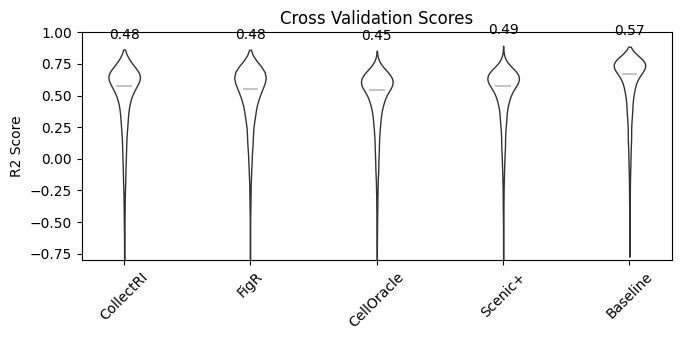

In [ ]:
# cross validation score
fig, ax = plt.subplots(1, 1, figsize=(7, 3.5), sharey=False)
data_dict = cv_scores_genes_dict

offset_amount = 0.4  # Control the offset amount for plots and text
legend_colors = ['purple', 'orange']
colors_map = {'purple': 'Inferred weight', 'orange': 'Inferred sign', 'white':''}
data_for_plot = []
labels_for_plot = []
positions = []
colors = []
current_position = 1
category_positions = {}  # Recalculating category positions
for key in data_dict.keys():
    
    data_for_plot.append(data_dict[key])
    category_label = surragate_names.get(key, key)
    if category_label not in category_positions:
        category_positions[category_label] = current_position
        labels_for_plot.append(category_label)
        current_position += 2
    positions.append(category_positions[category_label])
    colors.append('white')
violin_parts = ax.violinplot(data_for_plot, positions=positions, 
                             showmeans=False, 
                             showmedians=True, 
                             showextrema=False)
handles = []  # To store legend handles

for i, pc in enumerate(violin_parts['bodies']):
    color = colors[i]
    pc.set_facecolor(color)
    pc.set_edgecolor('black')
    pc.set_alpha(.8)  # Ensuring the plot is fully opaque
    if colors_map[color] not in [h.get_label() for h in handles]:  # Avoid duplicate legend entries
        if color == 'white':
            continue
        handles.append(plt.Line2D([0], [0], color=color, linewidth=10, label=colors_map[color]))
keys = ['cmaxes', 'cmins', 'cbars', 'cmedians']
for key in keys:
    if key in violin_parts:
        violin_parts[key].set_edgecolor('#C4C4C4')

ax.set_xticks([pos for key, pos in category_positions.items()])
ax.set_xticklabels(labels_for_plot, rotation=45)
ax.set_title('Cross Validation Scores')
ax.set_ylabel('R2 Score')
ax.set_ylim([-.8, 1])
ax.legend(handles=handles, loc=(1.01,.8), frameon=False)
# Correcting text annotations with offset adjustments
for i, data in enumerate(data_for_plot):
    if len(data) == 0: continue  # Skip empty datasets
    mean_val = np.mean(data)
    text_pos = positions[i]
    plt.text(text_pos, max(data) + (0.1 * max(data)), f'{mean_val:.2f}', ha='center', color='black')
plt.tight_layout()
plt.show()

In [ ]:
[np.mean(cv_scores_genes_dict[name]) for name in cv_scores_genes_dict.keys()]
# cv_scores_genes_dict['baseline']

[0.476031730986451,
 0.4766071917584338,
 0.44806310904124724,
 0.4881166847218875,
 0.5696005646883828]

## Robustness analysis

### Random baseline

In [ ]:
# pool the predictions
y_submits = []
for name, enc_model in tqdm.tqdm(enc_models.items()):
    y_submits.append(enc_model.calculate_y_submit())
pool_ = np.concatenate([np.ndarray.flatten(y_submit) for y_submit in y_submits])


  0%|          | 0/5 [00:00<?, ?it/s]


AttributeError: 'model_encoder_raw' object has no attribute 'calculate_y_submit'

In [ ]:
y_submit_format = format_y_submit(y_submits[0])
y_submits_random = []
for i in range(100):
    y_submits_random.append(format_y_submit(np.random.choice(pool_, size=y_submit_format.shape)))

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
os.environ['KAGGLE_USERNAME'] = 'jalilnourisa'
os.environ['KAGGLE_KEY'] = '63552f12403af36f40106e6821e80327'
api = KaggleApi()
api.authenticate()
prefix = 'random'    

for i, y_submit_df in enumerate(y_submits_random):
    if i < 17:
        continue
    file_name = f'{prefix}_{i}'
    write_submit(y_submit_df, file_name)
    submit(file_name)

### Shuffle grn 

In [ ]:
prefix = 'shuffletest_100tf'
for name, grn in zip(['co_grn', 'figr_grn'], [co_grn, figr_grn]):
    file_name = f'{prefix}_{name}'
    print(file_name)
    y_submit = enc_model.calculate_y_submit()
    y_submit_df = format_y_submit(y_submit)
    write_submit(y_submit_df, file_name)
    submit(file_name)

    for i in range(20,100):
        grn_s = grn.copy()
        grn_s['source'] = grn_s['source'].sample(frac=1).reset_index(drop=True)
        grn_s['target'] = grn_s['target'].sample(frac=1).reset_index(drop=True)

        dup_flags = grn_s[['source','target']].duplicated()
        grn_s = grn_s[~dup_flags].reset_index(drop=True)
        if grn_s.duplicated().sum()>0:
            raise ValueError('')
        #-- create the model
        sm_name_svd_n = 100
        celltype_svd_n = 100

        enc_model = model_encoder(df_main_reg, grn_model=grn_s, shares={
                                            'sm_name':{'tf_x':sm_name_svd_n},
                                            'cell_type': {'tf_x':celltype_svd_n}
                                            })
        file_name = f'{prefix}_{name}_{i}'
        print(file_name)
        y_submit = enc_model.calculate_y_submit()
        y_submit_df = format_y_submit(y_submit)
        write_submit(y_submit_df, file_name)
        submit(file_name)

In [ ]:
df = get_kaggle_scores(prefix)
real  = df[df.grn_model=='figr_grn']
rest = df[df.grn_model!='figr_grn']
for score in ['public_test', 'private_test']:
    # print(rest[score].astype(float).mean())
    print(real[score].mean(), rest[score].astype(float).mean())

# df = get_kaggle_scores(prefix)
real  = df[df.grn_model=='co_grn']
rest = df[df.grn_model!='co_grn']
for score in ['public_test', 'private_test']:
    # print(rest[score].astype(float).mean())
    print(real[score].mean(), rest[score].astype(float).mean())

nan 0.5975
nan 0.7757000000000001
nan 0.5975
nan 0.7757000000000001


In [ ]:
from scipy import stats
real  = df[df.grn_model=='co_grn']
rest = df[df.grn_model!='co_grn']
for score in ['public_test', 'private_test']:
    # print(rest[score].astype(float).mean())
    print(real[score].mean(), rest[score].astype(float).mean())
    # Sample data: Replace 'sample_data' with your sample data array
    sample_data = rest[score].astype(float).values

    # # The single value you want to compare the sample against
    population_mean = real[score].astype(float).values[0]

    # # Perform the one-sample t-test
    print(population_mean)
    t_stat, p_value = stats.ttest_1samp(sample_data, population_mean)
    print(p_value)

0.594 0.6010487804878049
0.594
7.689253429425053e-09
0.767 0.7763170731707317
0.767
4.029174197131669e-09


In [ ]:
np.mean(cv_scores)

/root/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


nan

### Save

In [ ]:
# file_exist = os.path.isfile('../output/postprocess/CV/cv_scores.csv')
# if not file_exist:
#     print('create the file ')
#     save_format = pd.DataFrame({}, columns=['grn_model','original_data','cv_scheme', 'metric_type','score'])
#     save_format.to_csv('../output/postprocess/CV/cv_scores.csv')
# old_scores = pd.read_csv('../output/postprocess/CV/cv_scores.csv', index_col=0)
# cv_scores_df = pd.DataFrame({'grn_model':cv_scores_dict.keys(),'original_data':original_data, 'cv_scheme':cv_scheme, 'metric_type':metric_type, 'score': cv_scores_dict.values()})
# updated_scores = pd.concat([old_scores, cv_scores_df])
# updated_scores = updated_scores.reset_index(drop=True).drop_duplicates()
# updated_scores.to_csv('../output/postprocess/CV/cv_scores.csv')

## Plot 

In [ ]:
kaggle_scores_df = pd.read_csv('../output/postprocess/kaggle_scores_df.csv', index_col=0)
with open(f'../output/postprocess/CV/cv_scores_genes_dict_{original_data}_{only_sig_de}_{subset_genes}.json', 'r') as file:
    cv_scores_genes_dict = json.load(file)
    cv_scores_genes_dict = {key:np.asarray(values) for key,values in cv_scores_genes_dict.items()}

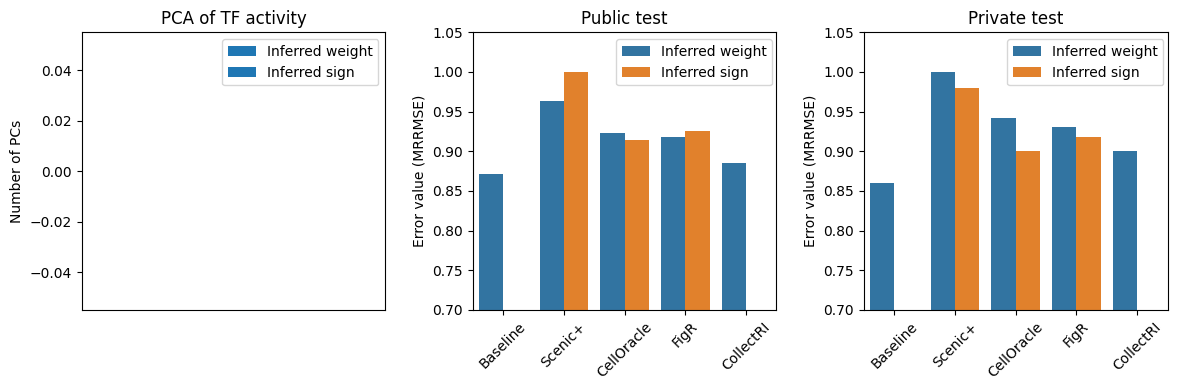

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=False)

# n components for TF acts
ax = axes[0]
data_dict = n_components_dict
normal_data = {k: v for k, v in data_dict.items() if "_sign" not in k}
signed_data = {k.replace("_sign", ""): v for k, v in data_dict.items() if "_sign" in k}
labels = list(normal_data.keys())
normal_values = [normal_data[label] for label in labels]
signed_values = [0 if (label=='collectRI') else signed_data[label] for label in labels ]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
rects1 = ax.bar(x - width/2, normal_values, width, label='Inferred weight')
rects2 = ax.bar(x + width/2, signed_values, width, label='Inferred sign')
ax.set_ylabel('Number of PCs')
ax.set_title('PCA of TF activity')
ax.set_xticks(x)
ax.set_xticklabels([surragate_names[label] for label in labels], rotation=45)
ax.legend()
# public and private test scores 
axes_ = axes[1:3]
def categorize_model(row):
    if '_sign' in row['grn_model']:
        return 'Inferred sign'
    else:
        return 'Inferred weight'
kaggle_scores_df['model_group'] = kaggle_scores_df['grn_model'].str.replace('_sign', '', regex=False)
kaggle_scores_df['category'] = kaggle_scores_df.apply(categorize_model, axis=1)
kaggle_scores_df['public_test'] = pd.to_numeric(kaggle_scores_df['public_test'], errors='coerce')
kaggle_scores_df['private_test'] = pd.to_numeric(kaggle_scores_df['private_test'], errors='coerce')
for i, score_type in enumerate(['public_test', 'private_test']):
    kaggle_scores_df[score_type] = kaggle_scores_df[score_type]/max(kaggle_scores_df[score_type])
    ax = axes_[i]
    sns.barplot(x='model_group', y=score_type, 
                hue='category', 
                data=kaggle_scores_df, 
                ax=ax, 
                dodge=True,
                )
    ax.set_title(f'{score_type.replace("_", " ").capitalize()}')
    ax.set_xticklabels([surragate_names[label] for label in kaggle_scores_df.model_group.unique()])
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('')
    ax.set_ylabel('Error value (MRRMSE)')
    ax.legend(title='', loc='upper left', bbox_to_anchor=(.45, 1))
    ax.set_ylim(0.7, 1.05)  # Adjust y-axis range

plt.tight_layout()


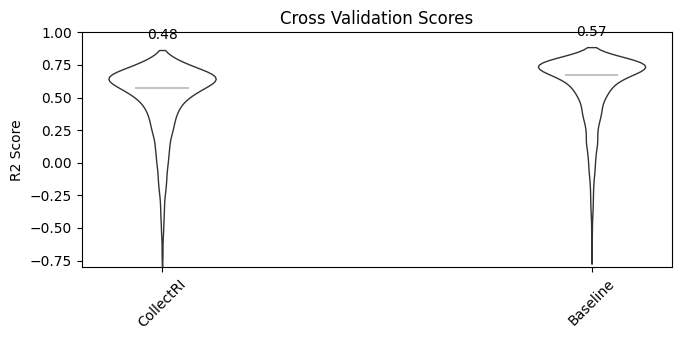

In [ ]:
# cross validation score
fig, ax = plt.subplots(1, 1, figsize=(7, 3.5), sharey=False)
data_dict = cv_scores_genes_dict

offset_amount = 0.4  # Control the offset amount for plots and text
legend_colors = ['purple', 'orange']
colors_map = {'purple': 'Inferred weight', 'orange': 'Inferred sign', 'white':''}
data_for_plot = []
labels_for_plot = []
positions = []
colors = []
current_position = 1
category_positions = {}  # Recalculating category positions
for key in data_dict.keys():
    if "sign" not in key and (key + "_sign") in data_dict:
        original_data_ = data_dict[key]
        signed_data = data_dict[key + "_sign"]
        data_for_plot += [original_data_, signed_data]
        category_label = surragate_names.get(key, key)
        if category_label not in category_positions:
            category_positions[category_label] = current_position
            labels_for_plot.append(category_label)
            current_position += 2  # Adjust for the next category, including space for offset
        # Adjust positions with the offset
        positions += [category_positions[category_label] - offset_amount, category_positions[category_label] + offset_amount]
        colors += legend_colors
    elif "baseline" in key or "collectRI" in key:
        data_for_plot.append(data_dict[key])
        category_label = surragate_names.get(key, key)
        if category_label not in category_positions:
            category_positions[category_label] = current_position
            labels_for_plot.append(category_label)
            current_position += 2
        positions.append(category_positions[category_label])
        colors.append('white')
violin_parts = ax.violinplot(data_for_plot, positions=positions, 
                             showmeans=False, 
                             showmedians=True, 
                             showextrema=False)
handles = []  # To store legend handles

for i, pc in enumerate(violin_parts['bodies']):
    color = colors[i]
    pc.set_facecolor(color)
    pc.set_edgecolor('black')
    pc.set_alpha(.8)  # Ensuring the plot is fully opaque
    if colors_map[color] not in [h.get_label() for h in handles]:  # Avoid duplicate legend entries
        if color == 'white':
            continue
        handles.append(plt.Line2D([0], [0], color=color, linewidth=10, label=colors_map[color]))
keys = ['cmaxes', 'cmins', 'cbars', 'cmedians']
for key in keys:
    if key in violin_parts:
        violin_parts[key].set_edgecolor('#C4C4C4')

ax.set_xticks([pos for key, pos in category_positions.items()])
ax.set_xticklabels(labels_for_plot, rotation=45)
ax.set_title('Cross Validation Scores')
ax.set_ylabel('R2 Score')
ax.set_ylim([-.8, 1])
ax.legend(handles=handles, loc=(1.01,.8), frameon=False)
# Correcting text annotations with offset adjustments
for i, data in enumerate(data_for_plot):
    if len(data) == 0: continue  # Skip empty datasets
    mean_val = np.mean(data)
    text_pos = positions[i]
    plt.text(text_pos, max(data) + (0.1 * max(data)), f'{mean_val:.2f}', ha='center', color='black')
plt.tight_layout()
plt.show()


In [ ]:
violin_parts.keys()

dict_keys(['bodies', 'cmaxes', 'cmins', 'cbars', 'cmedians'])